# Comparison w/ a test box

In this notebook I use the bias emulator to predict the halo bais in one of the test boxes.

In [1]:
import numpy as np
import aemulus_data as AD
import bias_emulator
import hmf_emulator
import aemulus_extras as ae
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc('errorbar', capsize=3)
plt.rc("font", size=14, family='serif')

In [3]:
cosmo_index = 2

In [4]:
#Create emulators
def get_emus(cosmo_index):
    #Note: we remove sigma8 from the list of parameters
    cosmology = AD.test_box_cosmologies()[cosmo_index][:-1]
    cosmo_dict = {"omega_b":cosmology[0], "omega_cdm":cosmology[1], "w0":cosmology[2],
             "n_s":cosmology[3], "ln10As":cosmology[4],"H0":cosmology[5],"N_eff":cosmology[6]}
    print("Cosmology for testing simulation %d loaded"%cosmo_index)
    Extras = ae.Extras(cosmo_index, testing=True)
    bias_emu = bias_emulator.bias_emulator()
    bias_emu.set_cosmology(cosmo_dict)
    hmf_emu = hmf_emulator.hmf_emulator()
    hmf_emu.set_cosmology(cosmo_dict)
    return bias_emu, hmf_emu, Extras

In [5]:
#Make a function to get halo data
def get_bias_data(box, snap):
    datapath = "./data_for_plots/"
    Masses, Mlos, Mhis, bias, bias_err = np.loadtxt(datapath+"TestBox%03d-combined_Z%d_DS50_linearbias.txt"%(box,snap), 
                                           unpack=True)
    Mhis[-1] = 10**16.5
    return Mlos, Mhis, Masses, bias, bias_err

redshifts = 1./AD.scale_factors() - 1
colors = [plt.get_cmap("seismic")(ci) for ci in np.linspace(1.0, 0.0, len(redshifts))]

In [6]:
#Write a function to get the correct bin-averaged bias
def bin_ave_biases_in_snap(box, snap, emu_and_extras):
    bias_emu, hmf_emu, Extras = emu_and_extras
    
    Mlos, Mhis, Masses, _, _ = get_bias_data(box, snap)
    
    Marr = np.logspace(np.log10(Mlos[0]), np.log10(Mhis[-1]), 1000)
    lnMarr = np.log(Marr)
    bias_at_Marr = bias_emu.bias(Marr, redshifts[snap])
    dndM_at_Marr = hmf_emu.dndM(Marr, redshifts[snap])
    
    bhmf_spl = IUS(lnMarr, bias_at_Marr*dndM_at_Marr*Marr)
    hmf_spl = IUS(lnMarr, dndM_at_Marr*Marr)

    lnMlos = np.log(Mlos)
    lnMhis = np.log(Mhis)
    
    output = np.zeros_like(Mlos)
    for i in range(len(output)):
        num = bhmf_spl.integral(lnMlos[i], lnMhis[i])
        den = hmf_spl.integral(lnMlos[i], lnMhis[i])
        output[i] = num/den
    return output

In [7]:
e_and_e = get_emus(cosmo_index)

Cosmology for testing simulation 2 loaded


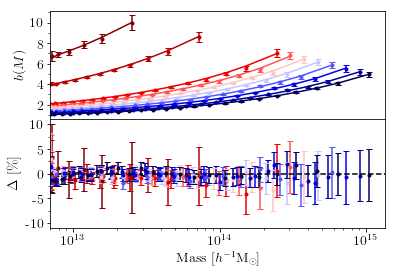

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)#, figsize=(9,4))
plt.subplots_adjust(hspace=0.0)
ax[0].set_xscale('log')
ax[0].set_ylabel(r"$b(M)$")
ax[1].set_ylabel(r"$\Delta\ [\%]$")
ax[1].set_xlabel(r"${\rm Mass}\ [h^{-1}{\rm M_\odot}]$")
ax[1].set_ylim(-11, 11)

ax[0].set_yticks([2,4,6,8,10])
ax[0].set_yticklabels([2,4,6,8,10])
ax[0].set_yticks([1,3,5,7,9,11], minor=True)
ax[1].set_yticks([-10, -5, 0, 5, 10])
ax[1].set_yticklabels([-10, -5, 0, 5, 10])
ax[1].set_yticks([-7.5, -2.5, 2.5, 7.5], minor=True)

MS = 6 #markersize
for snap in range(len(redshifts)):
    _, _, M, b, be = get_bias_data(cosmo_index, snap)
    
    bm = bin_ave_biases_in_snap(cosmo_index, snap, e_and_e)
    ax[0].plot(M, bm, c=colors[snap], zorder=-1)
    ax[0].errorbar(M, b, be, c=colors[snap], ls='', marker='.', markersize=MS)
    ax[1].errorbar(M, (b-bm)/bm*100, be/bm*100, c=colors[snap], ls='', marker='.', markersize=MS)

#ax[0].legend(frameon=False)
ax[1].axhline(0, c='k', ls='--')
xlims = ax[0].get_xlim()
_ = ax[0].set_xlim((7.0e12, xlims[1]))
fig.savefig("testbox_bias_figure.pdf", dpi=300, bbox_inches="tight")